---
layout: post  
---

The goal of this post is to evaluate the efficiency of two approaches for producing a consensus de-bruijn graph from a set of observed sequences ("reads") with a given error rate.

The consensus de-bruijn graph is produced by performing a viterbi-like maximum likehood path traversal for each observation and replacing the observation with it's maximum likelihood observation.

The two approaches that I've tried in the past and seem to work are:
1. iterate until converge, then increment k
    1. start with a given kmer length
    1. build the de bruijn graph from observations
    1. error-correct reads by evaluating their maximum likelihood path through the de bruijn graph
    1. rebuild the de bruijn graph with the maximum likelihood reads and repeat the error correction process until no more errors are corrected (convergence)
    1. increase the length of k (increment) and repeat the process all over again
1. continuously increment k
    1. start with a given kmer length
    1. build the de bruijn graph from observations
    1. error-correct reads by evaluating their maximum likelihood path through the de bruijn graph
    1. increase the k length (increment) and repeat the process over again using the error-corrected reads
    
In both methods we continue to error-correct reads with increasing k-lengths until we resolve a our original data into maximum likelihood sequences (and consequently, a maximum likelihood de bruijn graph and assembly).

However, the main question is whether it's worth it to repeat the process at each k-length until convergence, or just take whatever error-corrections we get from the first iteration at each k-length and keep going.

If we increase our k-length before converging, we may be carrying over erroneous kmers that will increase the size (and resulting analysis time) of the de-bruijn graph at the next step.

If the magnitude of these left-over, uncorrected errors is small, then we will waste more time by running another round of error-correction for little change (or no change at all), thus increasing the total number of error-correction rounds without increasing the total number of resolved errors.

We will try out the two approaches on a small, simulated dataset

In [11]:
import Pkg
pkgs = [
    "Eisenia",
    "Random",
    "Revise",
    "BioSequences",
    "Test",
    "LightGraphs",
    "Primes",
    "Statistics",
    "Plots"
]

for pkg in pkgs
    try
        Pkg.add(pkg)
    catch
        # tried to install an unregistered local package
    end
    eval(Meta.parse("import $pkg"))
end

  Resolving package versions...
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes

In [12]:
function my_plot(graph::Eisenia.KmerGraph)
    graph_hash = hash(sort(graph.graph.fadjlist), hash(graph.graph.ne))
    filename = "/assets/images/$(graph_hash).svg"
    p = Eisenia.plot_graph(graph)
    Plots.savefig(p, dirname(pwd()) * filename)
    display(p)
    display("text/markdown", "![]($filename)")
end

my_plot (generic function with 1 method)

In [13]:
n_sequences = 1
seqlen = 10
sequences = [BioSequences.randdnaseq(Random.seed!(i), seqlen) for i in 1:n_sequences]

1-element Array{BioSequences.LongSequence{BioSequences.DNAAlphabet{4}},1}:
 TCGTCCCAGG

Here we will simulate 100 observations of the original sequence with a 5% error rate and the observations happening randomly on either the forward or reverse complement strand

In [14]:
n_observations = 100
error_rate = 0.05

Random.seed!(1)
observations = [
    Eisenia.observe(rand(sequences), error_rate = error_rate) 
        for i in 1:n_observations
]

100-element Array{BioSequences.LongSequence{BioSequences.DNAAlphabet{4}},1}:
 CCTGGGACGA
 TCGTCCCAGG
 CCTGGGACGA
 CCTGGGATCGA
 CCTGGGACGA
 TCGTCCCAGG
 TCGTCCAGG
 TGTCCCAGG
 CCTGGGACGA
 CCTGGGACGA
 CCTGGGACCA
 TCGTCCCAGG
 CCTGGGACGA
 ⋮
 TCGTCCCAGCG
 TCGTCCCATG
 TCGTCCCAGG
 TCGTCCCAGG
 TCGTCCCAGG
 CCTGGGACGA
 CCTGGCGACGA
 TCGTCCCAGG
 TCGTCCCAGG
 TCACGTCCCGAGG
 CCTGGGACGA
 TCGCTCCCAGG

When plotting the log-log plot of # of kmers observed at a given frequency, we can see that there is a downward slope on the left 1/2 of the plot where a moderate number of kmers are observed relatively few times. This slope is composed of erroneous kmers that don't exist in the true sequence we are trying to resolve.

This downward sloping feature composed of erroneous data is in contrast to the peak on the right 1/2 of the plot where a small number of kmers are observed a relatively large number of times $$e^{4.5} \approxeq 90\text{x coverage}$$. These high-frequency kmers are the "true" kmers that are present in the true sequence we are trying to resolve.

Ideally, we're able to leverage the higher frequency of the "true" kmers to resolve/correct/eliminate the erroneous, lower frequency kmers

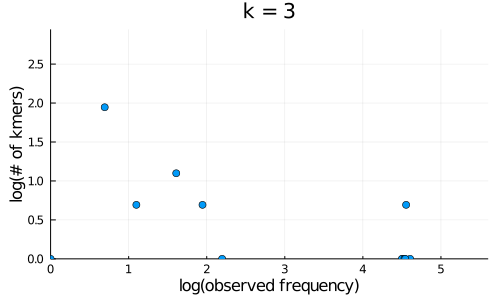

![](/assets/images/16007485645617828910.svg)

In [15]:
k = 3
counts = collect(values(Eisenia.count_kmers(BioSequences.DNAMer{k}, observations)))
p = Eisenia.plot_kmer_frequency_spectra(counts, title = "k = $k", size = (500, 300))
this_hash = hash(counts)
filename = "/assets/images/$(this_hash).svg"
Plots.savefig(p, dirname(pwd()) * filename)
display(p)
display("text/markdown", "![]($filename)")

Here we define a function for evaluating a set of observations with a given graph and a given error rate

In [16]:
function assess_observations(graph::Eisenia.KmerGraph{KMER_TYPE}, observations, error_rate) where {KMER_TYPE}
    k = last(KMER_TYPE.parameters)
    total_edits_accepted = 0
    total_bases_evaluated = 0
    reads_processed = 0
    maximum_likelihood_observations = Vector{BioSequences.LongDNASeq}(undef, length(observations))
    for (observation_index, observation) in enumerate(observations)
        if length(observation) >= k
            optimal_path, edit_distance, relative_likelihood = Eisenia.viterbi_maximum_likelihood_path(graph, observation, error_rate)
            maximum_likelihood_observation = Eisenia.oriented_path_to_sequence(optimal_path, graph.kmers)
            maximum_likelihood_observations[observation_index] = maximum_likelihood_observation
            reads_processed += 1
            total_bases_evaluated += length(observation)
            total_edits_accepted += edit_distance
        else
            maximum_likelihood_observations[observation_index] = observation
        end
    end
    inferred_error_rate = round(total_edits_accepted / total_bases_evaluated, digits = 3)
    display("reads_processed = $(reads_processed)")
    display("total_edits_accepted = $(total_edits_accepted)")
    display("inferred_error_rate = $(inferred_error_rate)")
    if total_edits_accepted == 0
        has_converged = true
    else
        has_converged = false
    end
    return maximum_likelihood_observations, has_converged
end

assess_observations (generic function with 1 method)

Here we define the first approach where we assert convergence before incrementing k

In [17]:
function converge_then_iterate(ks, observations, error_rate)
    for k in ks
        current_round = 1
        graph = Eisenia.KmerGraph(BioSequences.DNAMer{k}, observations)
        display("k = $k")
        display("current_round = $current_round")
        my_plot(graph)
        has_converged = false
        while !has_converged
            observations, has_converged = assess_observations(graph, observations, error_rate)
            display("round $current_round complete")
            current_round += 1
        end
        display("reached convergence, incrementing k")
    end
    graph = Eisenia.KmerGraph(BioSequences.DNAMer{last(ks)}, observations)
    display("final graph")
    my_plot(graph)
    return observations
end

converge_then_iterate (generic function with 1 method)

Here we define the second approach where we increment k regardless of convergence

In [18]:
function iterate_until_convergence(ks, observations, error_rate)
    for k in ks
        graph = Eisenia.KmerGraph(BioSequences.DNAMer{k}, observations)
        display("k = $k")
        my_plot(graph)
        observations, has_converged = assess_observations(graph, observations, error_rate)
    end
    graph = Eisenia.KmerGraph(BioSequences.DNAMer{last(ks)}, observations)
    display("final graph")
    my_plot(graph)
    return observations
end

iterate_until_convergence (generic function with 1 method)

In the following, we can see that the initial, messy de bruijn graph is nicely resolved after several rounds of error-correction into a concise 7-mer graph with a clear set of 4 high-coverage nodes with two low coverage tips that are likely unresolved errors. These can be easily clipped by downstream processing steps.

"k = 3"

"current_round = 1"

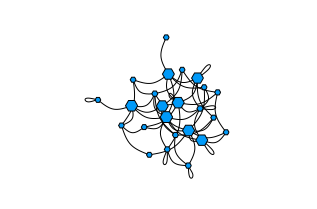

![](/assets/images/11516063661208544668.svg)

"reads_processed = 100"

"total_edits_accepted = 37"

"inferred_error_rate = 0.037"

"round 1 complete"

"reads_processed = 100"

"total_edits_accepted = 0"

"inferred_error_rate = 0.0"

"round 2 complete"

"reached convergence, incrementing k"

"k = 5"

"current_round = 1"

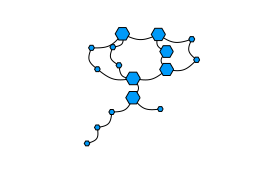

![](/assets/images/9366657123667438041.svg)

"reads_processed = 100"

"total_edits_accepted = 17"

"inferred_error_rate = 0.017"

"round 1 complete"

"reads_processed = 100"

"total_edits_accepted = 0"

"inferred_error_rate = 0.0"

"round 2 complete"

"reached convergence, incrementing k"

"k = 7"

"current_round = 1"

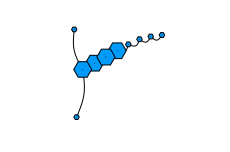

![](/assets/images/7625239065058145842.svg)

"reads_processed = 100"

"total_edits_accepted = 9"

"inferred_error_rate = 0.009"

"round 1 complete"

"reads_processed = 100"

"total_edits_accepted = 0"

"inferred_error_rate = 0.0"

"round 2 complete"

"reached convergence, incrementing k"

"final graph"

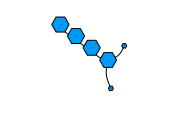

![](/assets/images/16902361047499149513.svg)

In [19]:
converge_then_iterate(Primes.primes(3, 7), observations, error_rate);

Of note in the above procedure, only the first round at each k-length produced any corrections, and the second evaluation where we assess for convergence doesn't yield any benefit (except for confirmation of futility)

In the below procedure where we increment k each time without waiting for convergence, we can see that we nicely resolve the initial messy de-bruijn graph into the same structure as the above procedure while skipping the "confirm convergence" round

"k = 3"

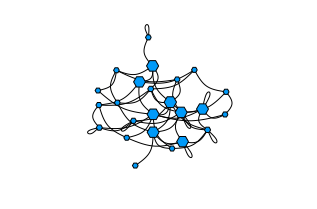

![](/assets/images/11516063661208544668.svg)

"reads_processed = 100"

"total_edits_accepted = 37"

"inferred_error_rate = 0.037"

"k = 5"

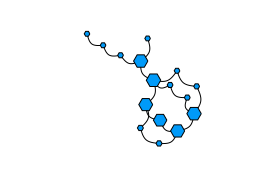

![](/assets/images/9366657123667438041.svg)

"reads_processed = 100"

"total_edits_accepted = 17"

"inferred_error_rate = 0.017"

"k = 7"

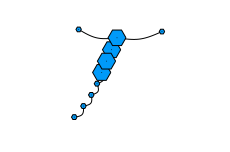

![](/assets/images/7625239065058145842.svg)

"reads_processed = 100"

"total_edits_accepted = 9"

"inferred_error_rate = 0.009"

"final graph"

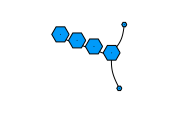

![](/assets/images/16902361047499149513.svg)

In [20]:
iterate_until_convergence(Primes.primes(3, 7), observations, error_rate);

Based on this small test, it seems worthwhile to increment k continuously without worrying about reaching convergence